In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['it was long since the rostovs had news of nicholas not till midwinter',
 'countess aliketurned to look at her as if wondering why she had said',
 'always thank god been my childrens friend and had their full',
 'mind her and all will come right and she wont say anything to mamma',
 'in the night he called his valet and told him to pack up to go to',
 'prince vasilis two valets were busy dressing him and he looked round',
 'to be happy with another kind of happiness the happiness of love and',
 'attendez said anna pavlovna reflecting ill speak to lise young',
 '',
 'on the opposite side the enemy could be seen by the naked eye and from']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[-0.7494,  0.0604,  0.3148,  ...,  0.4406, -1.0552,  0.7153],
        [ 0.6525, -0.1108,  0.2545,  ...,  1.7348,  0.4307,  0.3105],
        [ 1.3190,  0.8827, -0.1429,  ..., -1.1174, -2.8996,  0.0415],
        ...,
        [ 1.2961,  0.4175,  0.7320,  ..., -0.6569,  0.1921, -0.9948],
        [-0.4442, -2.1132, -1.1001,  ..., -0.1058,  1.0126,  0.3239],
        [ 0.0515, -0.3992, -1.0223,  ...,  0.2876, -1.3216,  0.6632]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 21:56:13.258000 137309090469696 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2313360188.py line 8 
W1027 21:56:13.258000 137309090469696 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 21:56:13.258000 137309090469696 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 21:56:13.258000 137309090469696 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 21:56:13.258000 137309090469696 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 21:56:13.258000 137309090469696 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 21:56:13.258000 137309090469696 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 21:56:13.258000 137309090469696 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 guarantees uswe unknown bathhouse gaunt sawcovered admit diese daredevil bigger indifference worried delayed nestlings faithfully bellowitz unbuttoned cest addressing attitude deliverer shot blister amuse scandals ladder wat scene hesitation handwriting declined pulse roundshouldered undivided murderer peered been si almighty tomorrow remorse wills assiduous fails husbandry detect unconciousness glad chaffingly womans bloody wed theirs meritthis burst correspondent grounds sabretachekeep disliked greet plethoric arrivals twenty thought zeal treetops doppelkummel driedup athletic natural waist encumbered meditation happier failing joking childrens crash readingthe hooked attractive growling wellordered swarmed fulfilled faut white flaring scoundrel europe dueling tremulous separated noisy nonintervention blushed dumb pleased merry behaving
 explanation welt willingly trooper walls commonly dumb weary sighs summons amiably adversary fastened unnerved instinctively nearest increasing ind

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([1024, 320])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


In [15]:
len(stoi)

11189

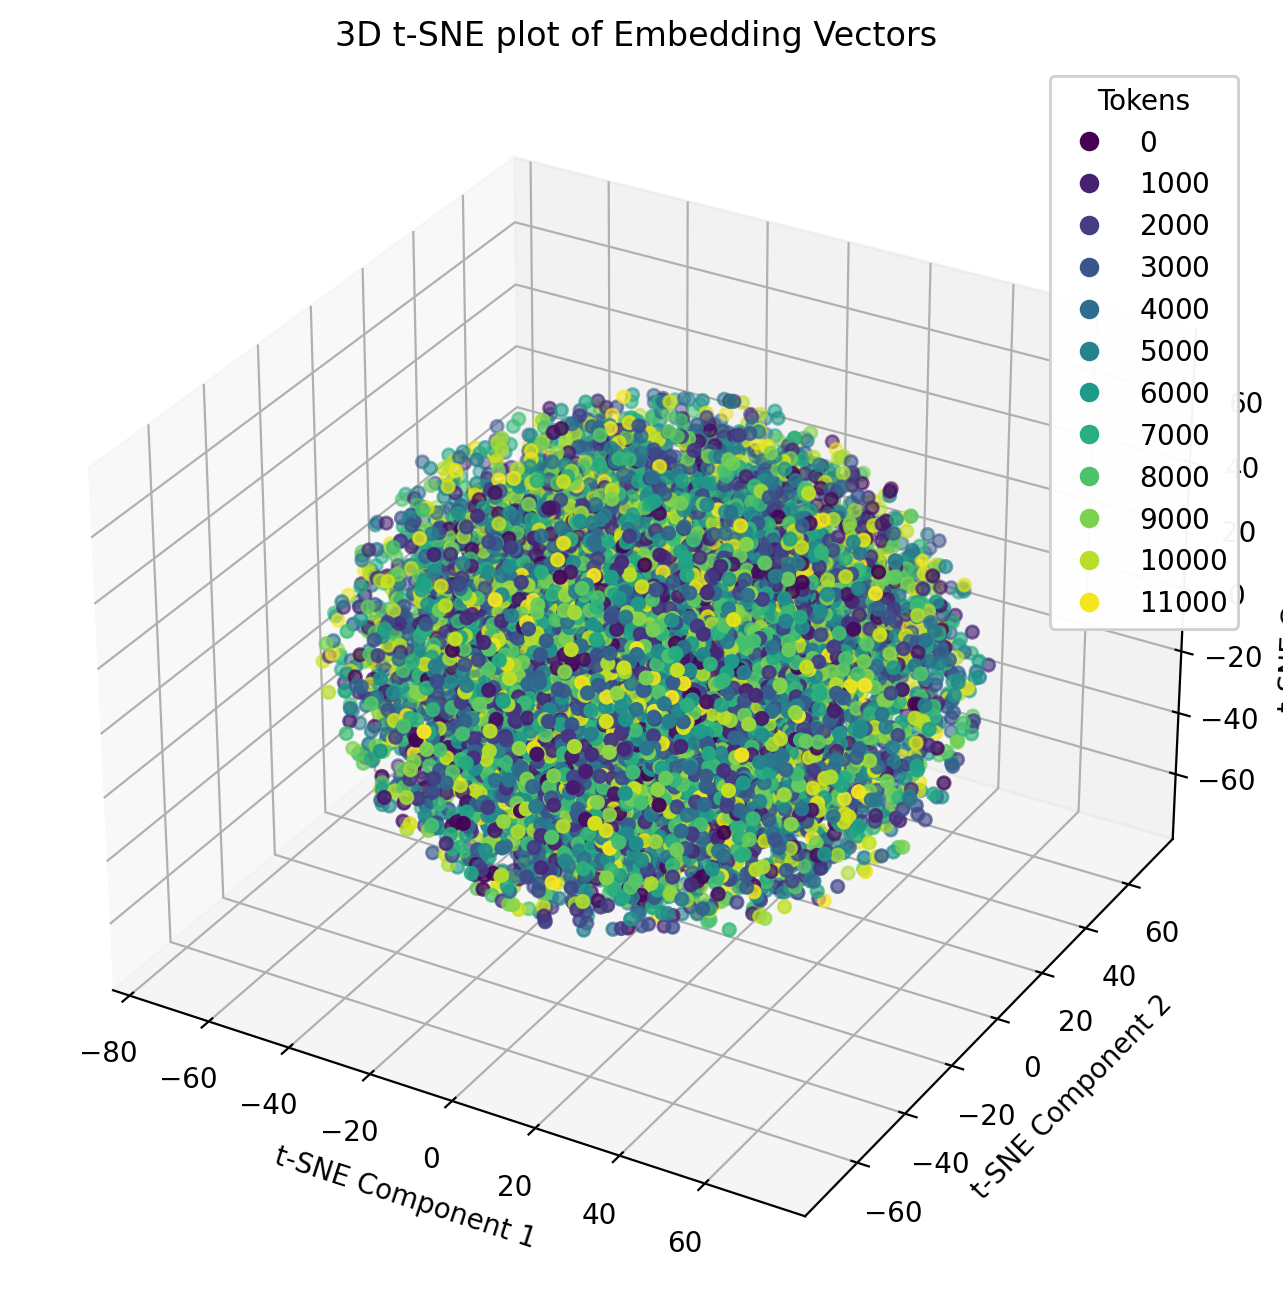

In [16]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


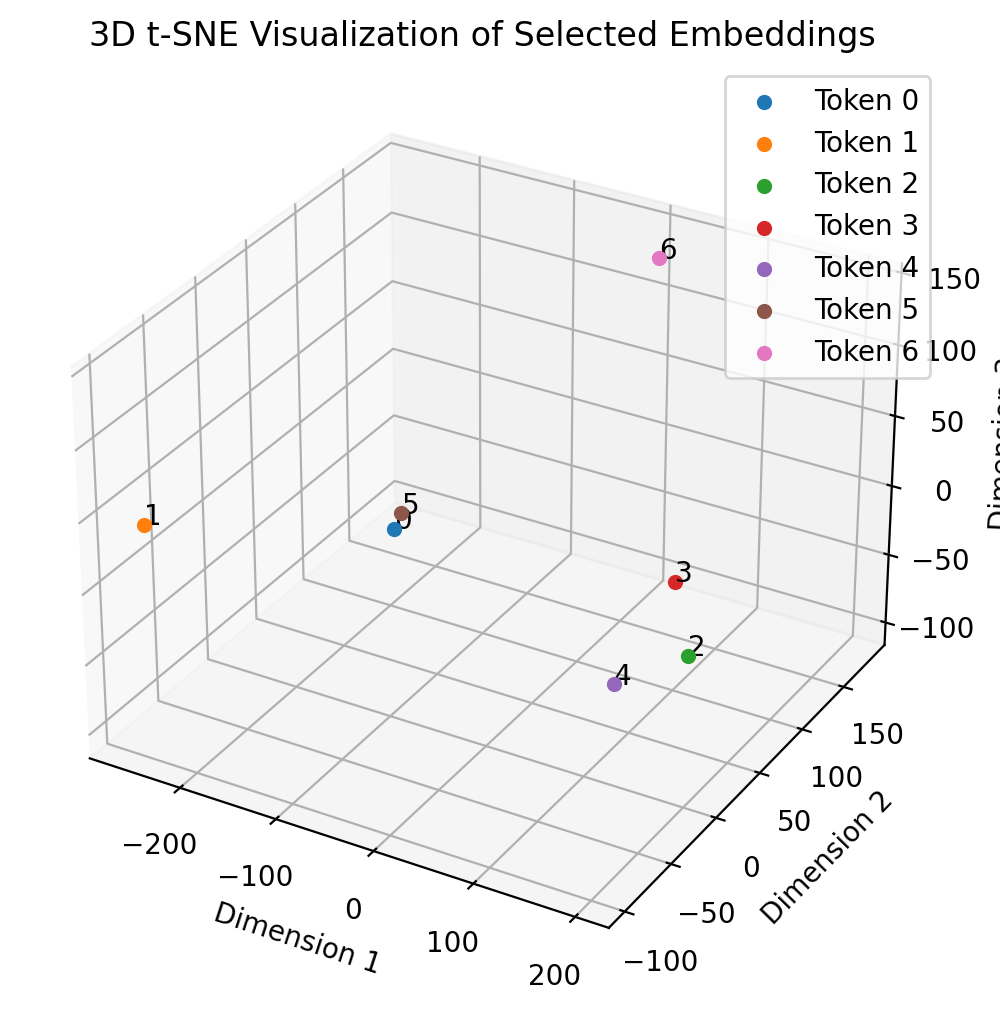

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

emb_curr = model.emb
embedding_matrix = emb_curr.weight.detach().cpu()

list_of_similar = ["battle",
"bloodshed",
"combat",
"conflict",
"fighting",
"strike",
"struggle"]

list_of_similar_token = []
for i in list_of_similar:
    list_of_similar_token.append(stoi[i])
indices = torch.tensor(list_of_similar_token) 

embeddings = torch.index_select(embedding_matrix, 0, indices)

tsne = TSNE(n_components=3, perplexity = 2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the 3D t-SNE result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with a label
for i, coord in enumerate(reduced_embeddings):
    ax.scatter(coord[0], coord[1], coord[2], label=f'Token {i}')
    ax.text(coord[0], coord[1], coord[2], f'{i}', fontsize=10)

ax.set_title("3D t-SNE Visualization of Selected Embeddings")
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

plt.legend()
plt.show()

In [21]:
import time
l1_lambda = 0.0001  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(200):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 6.122982025146484
Epoch 10, Loss: 6.082821846008301
Epoch 20, Loss: 6.068767070770264
Epoch 30, Loss: 6.0533905029296875
Epoch 40, Loss: 6.041147708892822
Epoch 50, Loss: 6.0306172370910645
Epoch 60, Loss: 6.019136905670166
Epoch 70, Loss: 6.007046699523926
Epoch 80, Loss: 5.994000434875488
Epoch 90, Loss: 5.983519554138184
Epoch 100, Loss: 5.972464561462402
Epoch 110, Loss: 5.964130401611328
Epoch 120, Loss: 5.954980373382568
Epoch 130, Loss: 5.947004795074463
Epoch 140, Loss: 5.940507888793945
Epoch 150, Loss: 5.9338603019714355
Epoch 160, Loss: 5.926400184631348
Epoch 170, Loss: 5.918917179107666
Epoch 180, Loss: 5.9126434326171875
Epoch 190, Loss: 5.905542850494385


In [18]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 sadness have ceased for the reasson how still i am all now you come to me prince andrew let leave the rostovs i know nothing more joined sources prince vasili in
 remained perhaps not like the fascination just but had twice seen on all night till of
 
 feeling to see prince dolgorukov who had felt boris
 particularly while there
 from salzeneck cheekbones and a third steps salute themselves dismounted with her vexation word
 well wont only just a friend he would have
 
 
 he was afraid on around him the pretty women


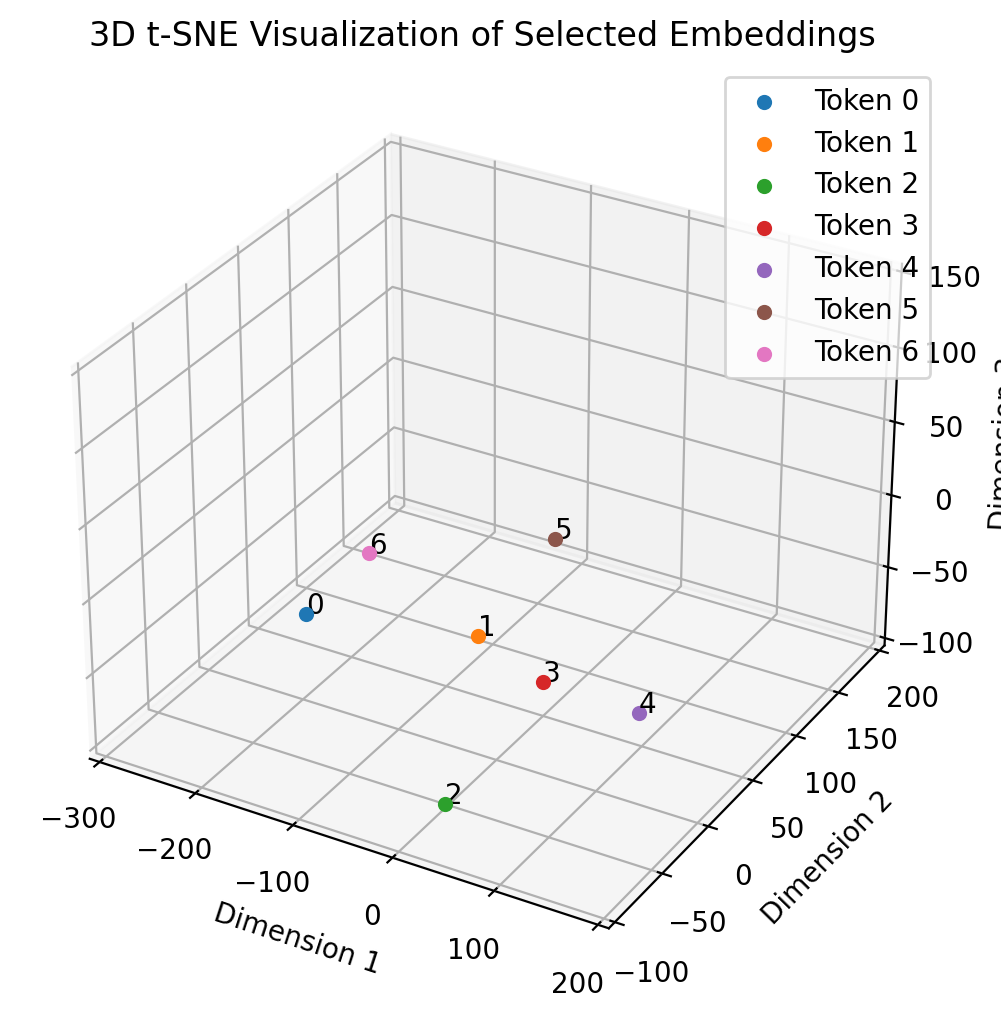

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

emb_curr = model.emb
embedding_matrix = emb_curr.weight.detach().cpu()

list_of_similar = ["battle",
"bloodshed",
"combat",
"conflict",
"fighting",
"strike",
"struggle"]

# list_of_similar = ["has", "had", "have"]

list_of_similar_token = []
for i in list_of_similar:
    list_of_similar_token.append(stoi[i])
indices = torch.tensor(list_of_similar_token) 

embeddings = torch.index_select(embedding_matrix, 0, indices)

tsne = TSNE(n_components=3, perplexity = 2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the 3D t-SNE result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with a label
for i, coord in enumerate(reduced_embeddings):
    ax.scatter(coord[0], coord[1], coord[2], label=f'Token {i}')
    ax.text(coord[0], coord[1], coord[2], f'{i}', fontsize=10)

ax.set_title("3D t-SNE Visualization of Selected Embeddings")
ax.set_xlabel('Dimension 1')
ax.set_xlim(-300,200)
ax.set_ylabel('Dimension 2')
ax.set_ylim(-100,200)

ax.set_zlabel('Dimension 3')
ax.set_zlim(-100,150)

plt.legend()
plt.show()

In [19]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


KeyboardInterrupt: 

In [ ]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_64_1024_t.pth")

In [ ]:
model = model.to(device)